# Import

In [1]:
#source
#region

#import
#region
import math
from sympy import *
import matplotlib.pyplot as plt
from numpy import linspace
import numpy as np
from sympy.codegen.cfunctions import log10
from sympy.abc import x,t,y
from sympy.plotting import plot
#endregion

#symbol declaration
#region
x, t = symbols('x t')
f = symbols('f', cls=Function)
#endregion

# Read Input

In [2]:
#input, output
#region
def ReadInput(file):
    f = file.readline()
    (lowT, upT) = map(lambda s: N(s), file.readline().split(","))
    (lowX, upX) = map(lambda s: N(s), file.readline().split(","))
    (t0, x0) = map(lambda s: N(s), file.readline().split(","))
    epsilon = N(file.readline())
    return (f, lowT, upT, lowX, upX, t0, x0, epsilon)
#endregion

# Main Function

In [3]:
def Pica1(f, deltaT, deltaX, t0, x0, M, L, epsilon, mode = ""):
    
    N = GetN(M, L, deltaT, deltaX, epsilon)
    xn = SymbolicIntegrate(f, t0, x0, N, mode)

    return xn

def Pica2(f, deltaT, t0, x0, M, L, epsilon, length = 69, mode = ""):
    
    xn = []
    segmentLength = 2 * deltaT / length
    n = (int)(length / 2)
    for i in range(-n, n + 1):
        xn.append([t0 + i * segmentLength, x0])

    xn = NumericIntegrate(f, xn, x0, segmentLength, epsilon, mode)

    return xn

def Pica(filename, length = None, M = None, L = None, deltaT = None, mode = ""):
    try:
        file = open(filename, "r")
        (f, lowT, upT, lowX, upX, t0, x0, epsilon) = ReadInput(file)
        f = sympify(f)
    except:
        raise ValueError("invalid Pica input")
    file.close()
    
    if not lowX< x0 <upX or not lowT< t0< upT:
        raise ValueError("invalid Pica input")
        
    if M is None:
        M = GetM(x, lowT, upT, lowX, upX)
    else:
        if M <= 0:
            raise ValueError("invalid Pica input")
        
        
    if L is None:
        L = GetL(x, lowT, upT, lowX, upX)
    else:
        if L < 0:
            raise ValueError("invalid Pica input")
    if L == 0:
        SymbolicIntergrate(f, t0, x0, 1, mode)
        
    deltaX = min(x0 - lowX, upX - x0)
    if deltaT is None:
        deltaT = min(deltaX / M, 1 / (2 * L), t0 - lowT, upT - t0)
    interval = (float(t0-deltaT), float(t0+deltaT))
    if length is None:
        return (Pica1(f, deltaT, deltaX, t0, x0, M, L, epsilon, mode), interval)
    return Pica2(f, deltaT, t0, x0, M, L, epsilon, length, mode)

# Main loop (integrate)

In [4]:

#region
def NumericIntegrate(f, xn, x0, segmentLength, epsilon, mode = ""):
    n = (int) (len(xn)/2)
    segmentLength /=2
    maxError = -math.inf
    loop = 0
    while abs(maxError) > epsilon:
        if mode == "test":
            dx = []
        loop += 1
        maxError = -math.inf
        
        integral = 0
        for i in range(n, 0, -1):
            integral = integral - segmentLength * (f.subs([(t, xn[i][0]), (x, xn[i][1])]) + f.subs([(t, xn[i - 1][0]), (x, xn[i - 1][1])]))
            newValue = x0 + integral
            error = abs(xn[i - 1][1] - newValue)
            xn[i - 1][1] = newValue
            if(error > maxError): maxError = error
            if mode == 'test':
                dx.append((xn[i][0], error))

        integral = 0
        for i in range(n, 2 * n):
            integral = integral + segmentLength * (f.subs([(t, xn[i][0]), (x, xn[i][1])]) + f.subs([(t, xn[i + 1][0]), (x, xn[i + 1][1])]))
            newValue = x0 + integral
            error = abs(xn[i + 1][1] - newValue)
            xn[i + 1][1] = x0 + integral
            if(error > maxError): maxError = error
            if mode == 'test':
                dx.append((xn[i][0], error))
                
        if mode == "test":
            print("Lặp lần ", loop, " với max error = ", maxError)
            PlotPairs(dx)
            plt.show()
    return xn

def GetN(M, L, deltaT, deltaX, epsilon, mode = ""):
    h = deltaT * L
    N = 1
    error = M * deltaT
    while error > epsilon:
        N+=1
        error = error * h / N
    return N

def SymbolicIntegrate(f, t0, x0, N, mode = ''):
     xn = x0
     for i in range(0,N):
        if mode == 'test':
            print(xn.evalf(2))
        xn = x0 + integrate(f.replace(x,xn), (t,t0,t))
     return xn

#endregion


# Not implemented supremum finder

In [5]:
# sup
#region
def GetM(f, lowT, upT, lowX, upX):
    #not implemented
    return 10
def GetL(f, lowT, upT, lowX, upX):
    #not implemented
    return 10

#endregion

# Plot

In [6]:
#plot
#region
def PlotPairs(pairList):
    t,x = zip(*pairList)
    plt.scatter(t,x)

def PlotSymbol(symbolOutput):
    func, interval = symbolOutput
    #t = linspace(interval[0], interval[1], 1000)
    #func = t**3/3 + t**7/67
    plot((func, (t, interval[0], interval[1])))
    
def PlotBoth(symbolOutput, pairList):
    t1, x1 = zip(*pairList)
    plt.scatter(t1,x1)
    func, interval = symbolOutput
    t_vals = linspace(interval[0], interval[1], 1000)
    lam_x = lambdify(t, func, modules=['numpy'])
    x_vals = lam_x(t_vals)
    plt.plot(t_vals, x_vals)

def Plot(f, interval):
    t_vals = linspace(interval[0], interval[1], 1000)
    lam_x = lambdify(t, f, modules = ['numpy'])
    x_vals = lam_x(t_vals)
    plt.plot(t_vals, x_vals)
    #plt.show()
#endregion


# Test

Lặp lần  1  với max error =  0.0725242623166003


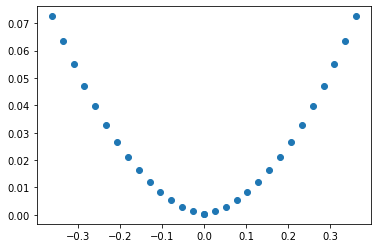

Lặp lần  2  với max error =  0.00305741770748913


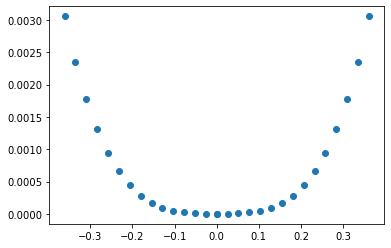

Lặp lần  3  với max error =  9.38783687298717e-5


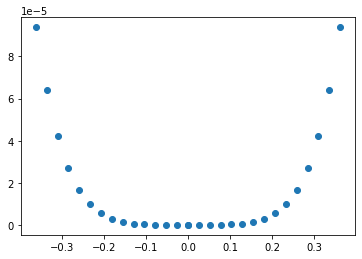

Lặp lần  4  với max error =  2.33879429800687e-6


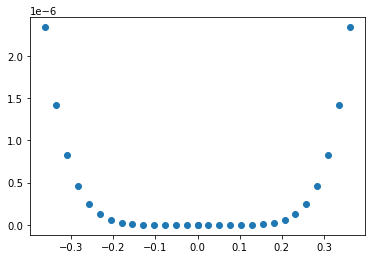

Lặp lần  5  với max error =  5.01243340167434e-8


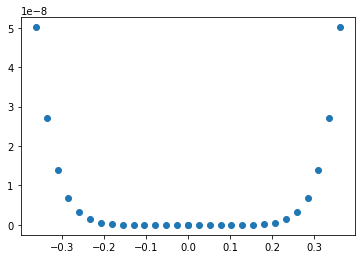

Lặp lần  6  với max error =  9.58262136308008e-10


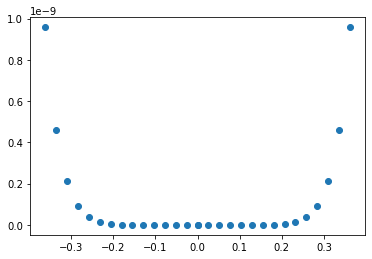

1.4e-6*t**18 - 1.2e-5*t**16 + 9.9e-5*t**14 - 0.00069*t**12 + 0.0042*t**10 - 0.021*t**8 + 0.083*t**6 - 0.25*t**4 + 0.5*t**2 + 1.0
Khoảng hội tụ: (-0.4, 0.4)


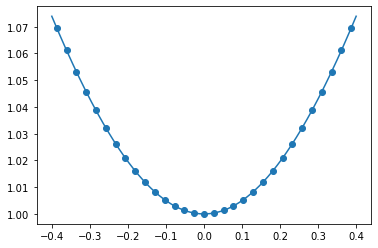

In [8]:
filename = "input2.txt"

result = Pica(filename, M = 2.5, L = 1)
result1 = Pica(filename, M = 2.5, L = 1, length = 31, mode = 'test')

print(result[0].evalf(2))
print("Khoảng hội tụ:", result[1])
PlotBoth(result, result1)

-8.3e+2*t**5 + 4.2e+2*t**4 - 1.7e+2*t**3 + 50.0*t**2 - 10.0*t + 1.0
Khoảng hội tụ: (-0.039999999999999994, 0.039999999999999994)
-0.0161290322580645


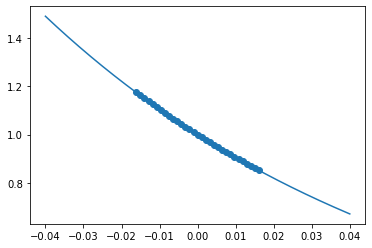

In [9]:
filename = "input3.txt"

result = Pica(filename, M = 5, L = 10)
result1 = Pica(filename, length = 31, M = 12, L = 10)

print(result[0].evalf(2))
print("Khoảng hội tụ:", result[1])
PlotBoth(result, result1)
print(result1[0][0])


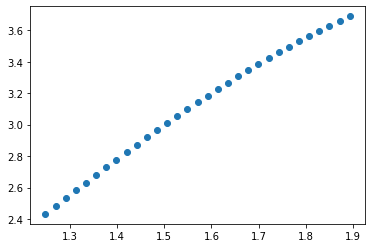

In [11]:
filename = "input4.txt"

#result = Pica(filename, M = 15, L = 1.5)
result1 = Pica(filename, length = 31, M = 15, L = 1.5)

PlotPairs(result1)
#print(result)
#PlotBoth(result, result1)

Lặp lần  1  với max error =  0.00473117832765528


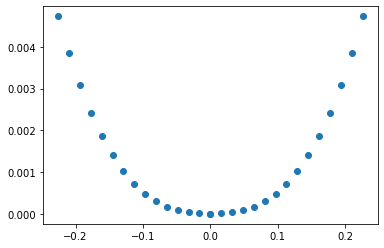

Lặp lần  2  với max error =  4.83782715461796e-7


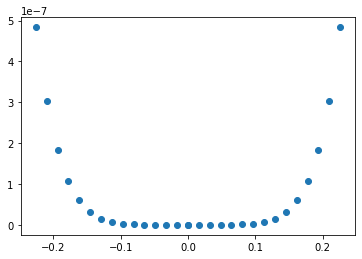

1.4e-50*t**127 + 7.9e-48*t**123 + 2.2e-45*t**119 + 3.9e-43*t**115 + 5.0e-41*t**111 + 5.1e-39*t**107 + 4.2e-37*t**103 + 3.0e-35*t**99 + 1.8e-33*t**95 + 9.7e-32*t**91 + 4.6e-30*t**87 + 2.0e-28*t**83 + 8.0e-27*t**79 + 2.9e-25*t**75 + 9.8e-24*t**71 + 3.1e-22*t**67 + 9.1e-21*t**63 + 2.5e-19*t**59 + 6.6e-18*t**55 + 1.6e-16*t**51 + 3.8e-15*t**47 + 8.5e-14*t**43 + 1.8e-12*t**39 + 3.7e-11*t**35 + 7.1e-10*t**31 + 1.3e-8*t**27 + 2.3e-7*t**23 + 3.7e-6*t**19 + 6.0e-5*t**15 + 0.00096*t**11 + 0.016*t**7 + 0.33*t**3
Khoảng hội tụ: (-0.25, 0.25)


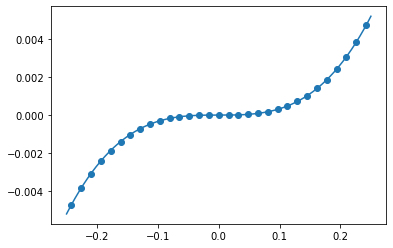

In [12]:
filename = "input1.txt"
result = Pica(filename, M = 2, L = 1)
result1 = Pica(filename, length = 31, M = 2, L = 1, mode = 'test')

print(result[0].evalf(2))
print("Khoảng hội tụ:", result[1])
PlotBoth(result, result1)
#Plot(sin(10*t) + cos(10*t), result[1])
#plt.show()

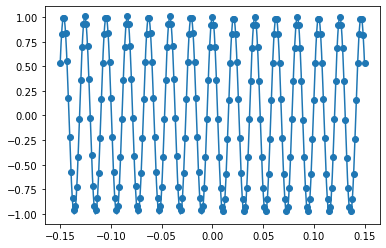

In [13]:
filename = "input5.txt"

result1 = Pica(filename, length = 222, M = 50, L = 1)
PlotPairs(result1)
interval = (float(result1[0][0]), float(result1[len(result1)-1][0]))
Plot(cos(300*t), interval)
plt.show()

Lặp lần  1  với max error =  0.503042309615621


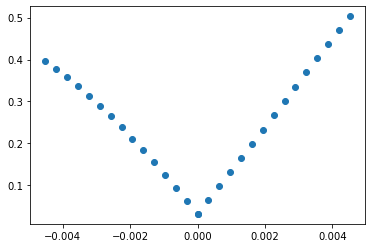

Lặp lần  2  với max error =  0.0697935373260953


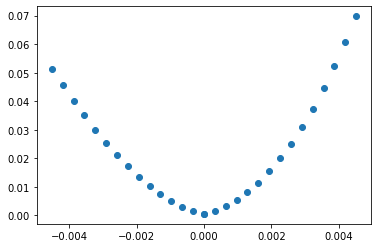

Lặp lần  3  với max error =  0.00658971014473408


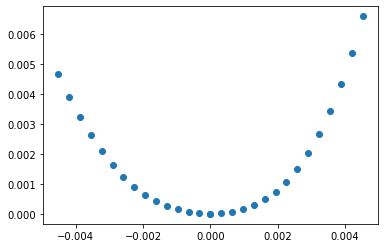

Lặp lần  4  với max error =  0.000487076059104807


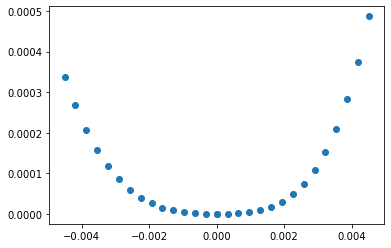

Lặp lần  5  với max error =  3.02004429240110e-5


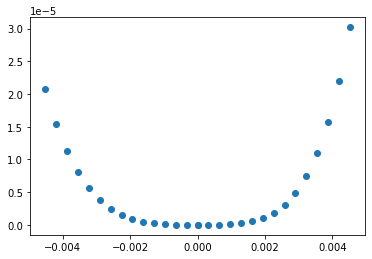

Lặp lần  6  với max error =  1.63666914787530e-6


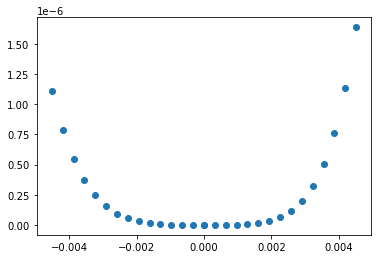

Lặp lần  7  với max error =  7.96548752513004e-8


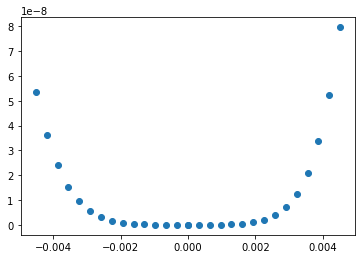

(-248015873015.873*t**8 - 19841269841.2698*t**7 + 1388888888.88889*t**6 + 83333333.3333333*t**5 - 4166666.66666667*t**4 - 166666.666666667*t**3 + 5000.0*t**2 + 100.0*t - 1.0, (-0.005, 0.005))


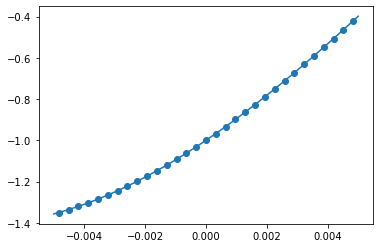

In [227]:
filename = "input6.txt"

result = Pica(filename, M = 250, L = 100)
result1 = Pica(filename, length = 31, M = 250, L = 100, mode = 'test')

print(result[0].evalf(2))
print("Khoảng hội tụ:", result[1])
PlotBoth(result, result1)
#interval = (float(result1[0][0]), float(result1[len(result1)-1][0]))
#Plot(sin(100*t), interval)